In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [68]:
flags = pd.read_feather('../data/all_flags.feather')
tf_idf = pd.read_feather('../data/flag_description_tf_idf.feather')

In [69]:
flags

,Flag(s),State,Aspect ratio,Date of latest adoption,Designer(s),Description,path
0,Afghanistan (Islamic Emirate),Afghanistan,0.500000,2021-08-15,None,White with a black Shahada in Thuluth scrip...,..\data\flags\0-220px-Flag_of_the_Taliban.svg.png
1,Afghanistan (Islamic Republic),Afghanistan,0.666667,2013-08-19,None,Three equal vertical bands of black ( hoist s...,..\data\flags\1-220px-Flag_of_Afghanistan_%282...
2,Albania,Albania,0.714286,1992-04-07,None,Red with a black double-headed eagle in the ...,..\data\flags\2-220px-Flag_of_Albania.svg.png
3,Algeria,Algeria,0.666667,1962-07-03,Disputed,Two equal vertical bands of green (hoist side)...,..\data\flags\3-220px-Flag_of_Algeria.svg.png
4,Andorra,Andorra,0.700000,1993-05-05,None,"Three vertical bands of blue (hoist side), yel...",..\data\flags\4-220px-Flag_of_Andorra.svg.png
...,...,...,...,...,...,...,...
208,Somaliland,Somaliland,NaN,1996-10-14,None,"Three equal horizontal bands of green (top), w...",..\data\flags\208-220px-Flag_of_Andorra.svg.png
209,South Ossetia,South Ossetia,NaN,NaT,None,"Three equal horizontal bands of white (top), r...",..\data\flags\209-220px-Flag_of_Angola.svg.png
210,Taiwan,Taiwan,0.666667,1928-10-28,Lu Haodong (canton) Sun Yat-sen (red field),Red field with a dark blue rectangle in the up...,..\data\flags\210-220px-Flag_of_Antigua_and_Ba...
211,Transnistria,Transnistria,0.500000,2000-07-03,None,"Three horizontal bands of red (top), green (ha...",..\data\flags\211-220px-Flag_of_Argentina.svg.png


In [70]:
data = pd.DataFrame({'flag-country': flags.apply(lambda r: f'{r['Flag(s)']}-{r['State']}', axis=1)}).join(tf_idf)
data

,flag-country,white,with,a,black,,shahada,in,thuluth,script,...,tiara,base,zimbabwe,dexter,hand,appaumé,kosovo,arrayed,slight,outline
0,Afghanistan (Islamic Emirate)-Afghanistan,0.020678,0.026676,0.022755,0.088128,0.0,0.266417,0.079238,0.291759,0.248437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,Afghanistan (Islamic Republic)-Afghanistan,0.008070,0.010410,0.000000,0.034391,0.0,0.000000,0.015461,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,Albania-Albania,0.000000,0.032832,0.028006,0.108465,0.0,0.000000,0.048762,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,Algeria-Algeria,0.010339,0.000000,0.022755,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,Andorra-Andorra,0.000000,0.008369,0.000000,0.000000,0.0,0.000000,0.012429,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Somaliland-Somaliland,0.026120,0.000000,0.019162,0.037107,0.0,0.112176,0.033363,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
209,South Ossetia-South Ossetia,0.022057,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
210,Taiwan-Taiwan,0.015039,0.038802,0.033098,0.000000,0.0,0.000000,0.028814,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
211,Transnistria-Transnistria,0.000000,0.009485,0.024272,0.000000,0.0,0.000000,0.014087,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11914


In [71]:
X = tf_idf
Y = data['flag-country']

In [72]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)

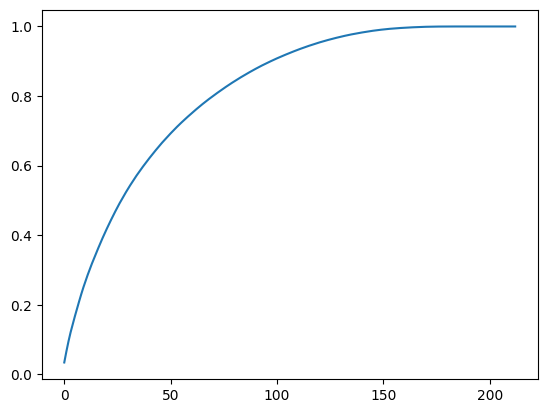

In [73]:
fig, ax = plt.subplots()

cum_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(cum_var)

plt.show()

In [74]:
all_var = np.argmin(cum_var < 1)
all_var

np.int64(186)

In [75]:
all_var = 100

In [76]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from tempfile import mkdtemp

cachedir = mkdtemp()
categorizers = list()

for pca_modes in [2, 3, 5, 10, 20, 50, 100, all_var]:
    for k in range(2, 16):
        pipe = make_pipeline(
            PCA(n_components=pca_modes, random_state=932),
            KMeans(n_clusters=k, random_state=42),
            memory=cachedir
        )
        
        categorizers.append(pipe)

n_variance = dict()
for cat in categorizers:
    cat.fit(X, Y)
    labels = cat.predict(X)
    categories = {label: Y[labels == label].values for label in np.unique(labels)}
    avg = np.average(list(map(len, categories.values())))
    var = np.average((np.fromiter(map(len, categories.values()), dtype=int) - avg)**2)
    n_variance[cat] = var

best = pipe = min(categorizers, key=n_variance.get)
print(best.get_params()['pca__n_components'], best.get_params()['kmeans__n_clusters'], n_variance[best])

categories = {label: Y[labels == label].values for label in np.unique(labels)}

3 15 234.6933333333333


In [77]:
{label: len(item) for label, item in categories.items()}

{np.int32(0): 5,
 np.int32(1): 90,
 np.int32(2): 26,
 np.int32(3): 9,
 np.int32(4): 21,
 np.int32(5): 1,
 np.int32(6): 1,
 np.int32(7): 48,
 np.int32(8): 1,
 np.int32(9): 1,
 np.int32(10): 1,
 np.int32(11): 3,
 np.int32(12): 2,
 np.int32(13): 1,
 np.int32(14): 3}

In [78]:
centers_2d = pipe.named_steps['kmeans'].cluster_centers_[:, :2]

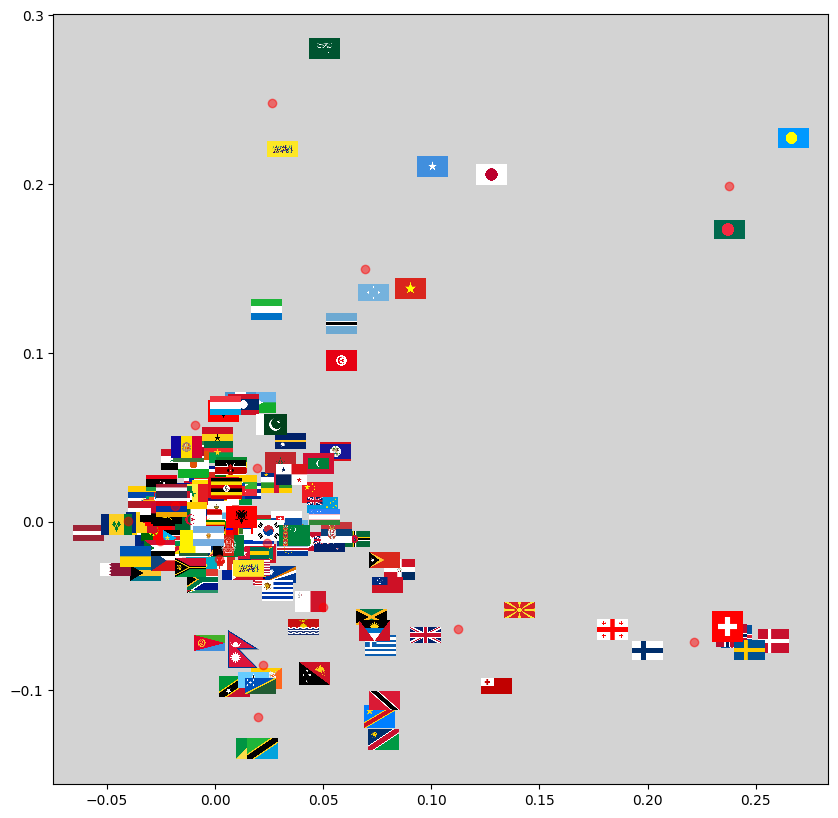

In [79]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(10,10))

pts = (X @ pca.components_[:2].T).T.values
# plt.scatter(*pts)

for i, (x, y) in enumerate(pts.T):
    image = plt.imread(flags['path'][i])
    offset_img = OffsetImage(image, zoom=0.1)
    abb = AnnotationBbox(offset_img, (x, y), xycoords='data', frameon=False)
    ax.add_artist(abb)

plt.scatter(*centers_2d.T, zorder=20, color='r', alpha=0.5)

ax.update_datalim(pts.T)
ax.autoscale()
ax.set_facecolor('lightgray')

plt.show()

In [112]:
# want to analyze the principal components for patterns

components = pca.inverse_transform(pca.components_[:3] @ X.T)
components.columns = tf_idf.columns

for idx, component in components.iterrows():
    sorted_words = sorted(components.columns, key=lambda c: component[c])
    
    print(f'{idx}: {sorted_words[:3]} vs {sorted_words[-3:]}')


0: ['yellow', 'triple', 'there'] vs ['band', '2', 'elliptical']
1: ['vermilion', 'austria', 'chrome'] vs ['shahada', 'flag', 'five']
2: ['closed', 'takbir', 'with'] vs ['in', 'radiant', 'stripe']


"elliptical" only shows up in the description for Costa Rica, and two of these words are conjunctions, this may not actually be that useful.

In [121]:
# Let's try to see what the "average" flag per category is described as
# I'm not sure how to 'undo' tf-idf, but luckily sklearn has a TfidfVectorizer, which I will hopefully implement soon...

avg_flags = pd.DataFrame(pipe.named_steps['pca'].inverse_transform(pipe.named_steps['kmeans'].cluster_centers_), columns=pipe.feature_names_in_)

,white,with,a,black,,shahada,in,thuluth,script,the,...,tiara,base,zimbabwe,dexter,hand,appaumé,kosovo,arrayed,slight,outline
0,0.009253,0.017485,0.015887,-0.010877,5.531050e-19,-0.016931,0.009527,-0.017419,-0.015909,0.027201,...,0.000401,-0.000635,-0.000635,-0.000303,-0.000303,-0.000303,-0.003434,-0.003434,-0.003434,-0.000382
1,0.010956,0.007932,0.011492,0.015153,-2.976734e-19,0.000819,0.010756,0.000284,0.001258,0.010764,...,0.000587,0.000537,0.000537,0.000721,0.000721,0.000721,0.001314,0.001314,0.001314,0.000683
2,0.016027,0.038106,0.030004,0.001905,5.332589e-18,0.053913,0.044131,0.058025,0.049736,0.026584,...,-0.000891,-0.000114,-0.000114,-0.000189,-0.000189,-0.000189,0.000391,0.000391,0.000391,-0.000421
3,0.009294,0.011526,0.016782,0.011030,5.157379e-19,-0.006362,0.011272,-0.006893,-0.005903,0.017582,...,0.000355,0.000424,0.000424,0.000970,0.000970,0.000970,0.001518,0.001518,0.001518,0.000524
4,0.011855,0.005759,0.006746,0.012393,-1.105879e-18,0.000319,0.008370,-0.000421,0.001116,0.008072,...,0.000828,0.000344,0.000344,0.000231,0.000231,0.000231,-0.000188,-0.000188,-0.000188,0.000586
5,0.005978,0.011370,0.026677,0.024134,1.746446e-18,-0.012537,0.012304,-0.013315,-0.012347,0.020758,...,-0.000055,0.001220,0.001220,0.002654,0.002654,0.002654,0.006518,0.006518,0.006518,0.001113
6,0.014779,0.025581,0.023712,0.016129,3.430064e-18,0.043336,0.034474,0.045994,0.040340,0.016342,...,-0.000412,0.000561,0.000561,0.000593,0.000593,0.000593,0.002761,0.002761,0.002761,0.000337
7,0.009238,0.012973,0.015444,0.002072,3.018687e-19,-0.012140,0.009443,-0.012794,-0.011292,0.020854,...,0.000437,-0.000015,-0.000015,0.000419,0.000419,0.000419,-0.000651,-0.000651,-0.000651,0.000170
8,0.011809,0.008562,0.009914,0.012842,-4.080159e-19,0.004024,0.011523,0.003668,0.004371,0.010139,...,0.000633,0.000390,0.000390,0.000385,0.000385,0.000385,0.000411,0.000411,0.000411,0.000562
9,0.013087,0.012297,0.011961,0.013877,3.701605e-19,0.016062,0.017370,0.016506,0.015544,0.010228,...,0.000427,0.000418,0.000418,0.000305,0.000305,0.000305,0.000734,0.000734,0.000734,0.000505


In [15]:
# This runs really slow for some reason

fig, ax = plt.subplots()

for label, group in categories.items():
    for i, flag in enumerate(group):
        image = plt.imread(flags[data['flag-country'] == flag]['path'].values[0])
        offset_img = OffsetImage(image, zoom=1)
        abb = AnnotationBbox(offset_img, (label, i))
        ax.add_artist(abb)

ax.autoscale()

plt.show()

KeyboardInterrupt: 